# Anthropic Financial Analyst Agent with Real-time News Access (built using Financial Modeling Prep and LlamaIndex)

## 1. Process <br>
This notebook is designed to retrieve financial data about a stock or company:

### Tools used:


1.   Anthropic API - Claude 3.5 Sonnett. Get your Claude API [here](https://console.anthropic.com/)
2.   LlamaIndex for orchestration
3.   Financial Modeling Prep API for stock information and news. Get a free API key [here](https://site.financialmodelingprep.com/)



In [3]:
!pip install llama-index-llms-anthropic -q
!pip install llama-index -q

In [4]:
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.openai import OpenAI
from llama_index.core.tools import FunctionTool

import nest_asyncio

nest_asyncio.apply()

## 2. Instantiate Anthropic and News API Keys

Step 1: Instantiate Baseline LLM to be used


*   Experiment 1: Use Claude Sonnet for tool use, code generation and parsing
*   Optional: Users can swap out Claude for OpenAI models to test different models and evaluate them



In [5]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLAUDE_API_KEY = userdata.get('ANTHROPIC_API_KEY')
FMP_API_KEY = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')

In [6]:
anthropic_llm = Anthropic(model="claude-3-5-sonnet-20240620", api_key=CLAUDE_API_KEY)

Step 2: Instantiate News API for Retrieval

## 3. Define Classes for Chaining Functions


*   Core StockAnalyzer class for base functionality
*   Specialized Engine classes for different types of analysis
*   Data classes for structured data representation


### 3.1. Core Stock Analyzer Class

1.   StockMetrics
2.   StockAnalyzer


In [8]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union, Any
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta

from google.colab import userdata
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import FunctionCallingAgent

@dataclass
class StockMetrics:
    """Data class to store key stock metrics"""
    price: float
    volume: int
    market_cap: float
    pe_ratio: float
    eps: float
    beta: float
    moving_avg_50: float
    moving_avg_200: float

class StockAnalyzer:
    def __init__(self):
        """
        Initialize the Stock analyst using Google Colab userdata for API key.
        """
        self.api_key = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')
        if not self.api_key:
            raise ValueError("FMP API key not found in Colab userdata")

        self.base_url = "https://financialmodelingprep.com/api/v3"
        self.pro_url = "https://financialmodelingprep.com/api/v4" ## Upgrade to Pro FMP subscription
        self.df = None
        self._fetch_data()

    def _fetch_data(self) -> None:
        """
        Fetch fresh data from the FMP API and update the internal dataframe.
        """
        url = f"{self.base_url}/quote?apikey={self.api_key}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            self.raw_data = response.json()
            self.df = pd.DataFrame(self.raw_data)
        except requests.exceptions.RequestException as e:
            raise Exception(f"Failed to fetch stock data: {str(e)}")
        except Exception as e:
            raise Exception(f"Error processing stock data: {str(e)}")

    def refresh_data(self) -> None:
        """
        Manually refresh the data from the API.
        """
        self._fetch_data()

### 3.2 Helper Functions for Agent Use

#### 3.2.1 Retrieve Quote and Profile Info - get_stock_metrics




In [9]:
# Helper Functions for Tool Use
def get_stock_metrics(symbol: str) -> Dict:
    """
    Get detailed stock metrics including price, volume, and key ratios.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/quote/{symbol}?apikey={analyzer.api_key}"
        profile_url = f"{analyzer.base_url}/profile/{symbol}?apikey={analyzer.api_key}"

        quote_data = requests.get(url).json()
        profile_data = requests.get(profile_url).json()

        if not quote_data or not profile_data:
            return {"error": f"No data found for symbol: {symbol}"}

        quote = quote_data[0]
        profile = profile_data[0]

        return {
            "symbol": symbol,
            "price": quote.get('price', 0),
            "change": quote.get('changesPercentage', 0),
            "volume": quote.get('volume', 0),
            "yearHigh": quote.get('yearHigh', 0),
            "yearLow": quote.get('yearLow', 0),
            "market_cap": profile.get('mktCap', 0),
            "pe_ratio": quote.get('pe', 0),
            "eps": quote.get('eps', 0),
            "beta": profile.get('beta', 0),
            "moving_avg_50": quote.get('priceAvg50', 0),
            "moving_avg_200": quote.get('priceAvg200', 0),
            "dcf": profile.get('dcf', 0),
            "website": profile.get('website', ''),
            "industry": profile.get('industry', ''),
            "sector": profile.get('sector', ''),
            "description": profile.get('description', '')
        }
    except Exception as e:
        return {"error": f"Failed to get stock metrics: {str(e)}"}

In [11]:
## Test Function

get_stock_metrics("CEIX")

{'symbol': 'CEIX',
 'price': 127.56,
 'change': -0.219,
 'volume': 205662,
 'yearHigh': 134.59,
 'yearLow': 75.43,
 'market_cap': 3749562420,
 'pe_ratio': 9.42,
 'eps': 13.54,
 'beta': 1.743,
 'moving_avg_50': 114.521,
 'moving_avg_200': 97.566,
 'dcf': 233.4617168633634,
 'website': 'https://www.consolenergy.com',
 'industry': 'Coal',
 'sector': 'Energy',
 'description': 'CONSOL Energy Inc. produces and exports bituminous coal in the United States. It operates through PAMC, CONSOL Marine Terminal, and Other segments. The company engages in the mining, preparation, and marketing of bituminous coal to power generators, industrial end-users, and metallurgical end-users; and provision of coal export terminal services, as well as development of the Itmann Mine and the Greenfield reserves. It owns and operates the Pennsylvania Mining Complex (PAMC), which includes the Bailey Mine, the Enlow Fork Mine, the Harvey Mine, and the Central Preparation Plant; and CONSOL Marine Terminal located in 

#### 3.2.2 Retrieve All Financial Statements


In [12]:
def get_income_statement(symbol: str) -> Dict:
    """
    Fetch detailed income statement data.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/income-statement/{symbol}?period=quarter&limit=4&apikey={analyzer.api_key}"

        response = requests.get(url)
        data = response.json()

        if not data:
            return {"error": "No income statement data found"}

        latest = data[0]
        return {
            "date": latest.get('date'),
            "revenue": latest.get('revenue'),
            "gross_profit": latest.get('grossProfit'),
            "net_income": latest.get('netIncome'),
            "operating_income": latest.get('operatingIncome'),
            "eps": latest.get('eps'),
            "ebitda": latest.get('ebitda'),
            "income_tax_expense": latest.get('incomeTaxExpense')
        }
    except Exception as e:
        return {"error": f"Failed to get income statement: {str(e)}"}

def get_balance_sheet(symbol: str) -> Dict:
    """
    Fetch detailed balance sheet data.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/balance-sheet-statement/{symbol}?period=quarter&limit=4&apikey={analyzer.api_key}"

        response = requests.get(url)
        data = response.json()

        if not data:
            return {"error": "No balance sheet data found"}

        latest = data[0]
        return {
            "date": latest.get('date'),
            "total_assets": latest.get('totalAssets'),
            "total_liabilities": latest.get('totalLiabilities'),
            "total_equity": latest.get('totalStockholdersEquity'),
            "cash_and_equivalents": latest.get('cashAndCashEquivalents'),
            "short_term_debt": latest.get('shortTermDebt'),
            "long_term_debt": latest.get('longTermDebt'),
            "working_capital": latest.get('totalCurrentAssets', 0) - latest.get('totalCurrentLiabilities', 0)
        }
    except Exception as e:
        return {"error": f"Failed to get balance sheet: {str(e)}"}

def get_cash_flow(symbol: str) -> Dict:
    """
    Fetch detailed cash flow statement data.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/cash-flow-statement/{symbol}?period=quarter&limit=4&apikey={analyzer.api_key}"

        response = requests.get(url)
        data = response.json()

        if not data:
            return {"error": "No cash flow data found"}

        latest = data[0]
        return {
            "date": latest.get('date'),
            "operating_cash_flow": latest.get('operatingCashFlow'),
            "investing_cash_flow": latest.get('netCashUsedForInvestingActivites'),
            "financing_cash_flow": latest.get('netCashUsedProvidedByFinancingActivities'),
            "capital_expenditure": latest.get('capitalExpenditure'),
            "free_cash_flow": latest.get('freeCashFlow'),
            "dividend_payments": latest.get('dividendsPaid')
        }
    except Exception as e:
        return {"error": f"Failed to get cash flow statement: {str(e)}"}

In [13]:
get_income_statement("CEIX")

{'date': '2024-09-30',
 'revenue': 549635000,
 'gross_profit': 182095000,
 'net_income': 95632000,
 'operating_income': 176967000,
 'eps': 3.23,
 'ebitda': 171164000,
 'income_tax_expense': 17539000}

In [14]:
get_balance_sheet("CEIX")

{'date': '2024-09-30',
 'total_assets': 2824117000,
 'total_liabilities': 1294622000,
 'total_equity': 1529495000,
 'cash_and_equivalents': 331674000,
 'short_term_debt': 112706000,
 'long_term_debt': 89269000,
 'working_capital': 204578000}

In [15]:
get_cash_flow("CEIX")

{'date': '2024-09-30',
 'operating_cash_flow': 161332000,
 'investing_cash_flow': -39199000,
 'financing_cash_flow': -9344000,
 'capital_expenditure': -39388000,
 'free_cash_flow': 121944000,
 'dividend_payments': -7353000}

#### 3.2.3 Get Key Metrics and Ratio

*   Profitability
*   Liquidity
*   Efficiency
*   Valuation



In [16]:
def get_key_metrics(symbol: str) -> Dict:
    """
    Get detailed valuation metrics and ratios.

    Args:
        symbol (str): Stock ticker symbol
    """
    try:
        analyzer = StockAnalyzer()
        url_metrics = f"{analyzer.base_url}/key-metrics-ttm/{symbol}?apikey={analyzer.api_key}"
        url_ratios = f"{analyzer.base_url}/ratios-ttm/{symbol}?apikey={analyzer.api_key}"

        metrics = requests.get(url_metrics).json()
        ratios = requests.get(url_ratios).json()

        return {
            "key_metrics": metrics[0] if metrics else None,
            "financial_ratios": ratios[0] if ratios else None
        }
    except Exception as e:
        return {"error": f"Failed to get valuation metrics: {str(e)}"}

In [18]:
get_key_metrics("AMR")

{'key_metrics': {'revenuePerShareTTM': 253.49321161300432,
  'netIncomePerShareTTM': 28.094104850120836,
  'operatingCashFlowPerShareTTM': 57.71073804984245,
  'freeCashFlowPerShareTTM': 40.98720062191673,
  'cashPerShareTTM': 37.22282225441741,
  'bookValuePerShareTTM': 126.7974975840809,
  'tangibleBookValuePerShareTTM': 123.60541165878773,
  'shareholdersEquityPerShareTTM': 126.7974975840809,
  'interestDebtPerShareTTM': 0.8843262543190795,
  'marketCapTTM': 3155989520,
  'enterpriseValueTTM': 2678112520,
  'peRatioTTM': 8.63063625958373,
  'priceToSalesRatioTTM': 0.9563810372889842,
  'pocfratioTTM': 4.201471133337238,
  'pfcfRatioTTM': 5.91492214617178,
  'pbRatioTTM': 1.9122617135185598,
  'ptbRatioTTM': 1.9122617135185598,
  'evToSalesTTM': 0.8115667094655673,
  'enterpriseValueOverEBITDATTM': 4.394433054987176,
  'evToOperatingCashFlowTTM': 3.5647898220075924,
  'evToFreeCashFlowTTM': 5.019290132017902,
  'earningsYieldTTM': 0.11586631274021873,
  'freeCashFlowYieldTTM': 0.1690

#### 3.2.4 Get Latest Company News - get_company_news

In [19]:
def get_company_news(symbol: str) -> Dict:
    """
    Get recent company news and press releases.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/stock_news?tickers={symbol}&limit=5&apikey={analyzer.api_key}"

        response = requests.get(url)
        news = response.json()

        if not news:
            return {"error": "No news found"}

        formatted_news = [{
            "title": item.get('title'),
            "date": item.get('publishedDate'),
            "source": item.get('site'),
            "url": item.get('url'),
            "summary": item.get('text')
        } for item in news]

        return {"news": formatted_news}
    except Exception as e:
        return {"error": f"Failed to get company news: {str(e)}"}

In [20]:
get_company_news("AMR")

{'news': [{'title': 'Thankful Investors - Last 5 Years',
   'date': '2024-11-25 15:32:00',
   'source': 'seekingalpha.com',
   'url': 'https://seekingalpha.com/article/4740164-thankful-investors-last-5-years',
   'summary': "We're highlighting the 25 best-performing stocks in the S&P 1500 on a total return basis over the last five years. At the top of the list, above even Nvidia, is Alpha Metallurgical, which mines and produces coal for steel production and power generation. NVDA ranks second, turning $1,000 five years ago into more than $25,000 today, followed by energy drink maker Celsius, MARA Holdings, and GameStop."},
  {'title': 'Alpha Metallurgical Resources: Still Undervalued, Reiterate Strong Buy Rating',
   'date': '2024-11-19 02:53:04',
   'source': 'seekingalpha.com',
   'url': 'https://seekingalpha.com/article/4738554-amr-reiterate-strong-buy-rating',
   'summary': 'I rate Alpha Metallurgical Resources as a strong buy due to its undervalued stock price, despite missing ear

#### (Optional) 3.2.5 Retrieve Insider Trading Activity - get_insider_trading

Note: This requires a Pro subscription for Financial Modeling Prep

In [21]:
def get_insider_trading(symbol: str) -> Dict:
    """
    Get recent insider trading activity.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.pro_url}/insider-trading?symbol={symbol}&apikey={analyzer.api_key}"

        response = requests.get(url)
        data = response.json()

        if not data:
            return {"error": "No insider trading data found"}

        formatted_trades = [{
            "filing_date": trade.get('filingDate'),
            "transaction_date": trade.get('transactionDate'),
            "transaction_type": trade.get('transactionType'),
            "insider_name": trade.get('reportingName'),
            "insider_type": trade.get('typeOfOwner'),
            "security_name": trade.get('securityName'),
            "shares": trade.get('securitiesTransacted'),
            "price": trade.get('price'),
            "value": (trade.get('price') * trade.get('securitiesTransacted')) if trade.get('price') and trade.get('securitiesTransacted') else None,
        } for trade in data[:10]]  # Last 10 trades

        return {"insider_trades": formatted_trades}
    except Exception as e:
        return {"error": f"Failed to get insider trading data: {str(e)}"}

In [22]:
get_insider_trading("AMR")

{'insider_trades': [{'filing_date': '2024-06-11 16:56:51',
   'transaction_date': '2024-06-01',
   'transaction_type': '',
   'insider_name': 'Manno Mark Matthew',
   'insider_type': '',
   'security_name': '',
   'shares': 0,
   'price': 0,
   'value': None},
  {'filing_date': '2024-06-04 16:42:29',
   'transaction_date': '2024-05-31',
   'transaction_type': 'A-Award',
   'insider_name': 'Nicholson Roger Lee',
   'insider_type': 'officer: CAO, GC & Secretary',
   'security_name': 'Common Stock, $0.01 par value per share',
   'shares': 7725,
   'price': 0,
   'value': None},
  {'filing_date': '2024-06-04 16:42:29',
   'transaction_date': '2024-05-31',
   'transaction_type': 'D-Return',
   'insider_name': 'Nicholson Roger Lee',
   'insider_type': 'officer: CAO, GC & Secretary',
   'security_name': 'Common Stock, $0.01 par value per share',
   'shares': 2579,
   'price': 0,
   'value': None},
  {'filing_date': '2024-06-04 16:42:29',
   'transaction_date': '2024-05-31',
   'transaction_ty

#### (Optional) 3.2.6. Retrieve Technical Indicators:


*   Technical Indicators for trtacking daily trading data
*   Not a fundamentals based approach but this will get covered in another notebook



In [23]:
def get_technical_indicators(symbol: str) -> Dict:
    """
    Get comprehensive technical analysis indicators.
    """
    try:
        analyzer = StockAnalyzer()
        url = f"{analyzer.base_url}/technical-indicator/daily/{symbol}?apikey={analyzer.api_key}"

        response = requests.get(url)
        data = response.json()

        if not data:
            return {"error": "No technical data found"}

        latest = data[0]
        return {
            "moving_averages": {
                "sma_20": latest.get('sma20'),
                "sma_50": latest.get('sma50'),
                "sma_200": latest.get('sma200'),
                "ema_20": latest.get('ema20'),
                "ema_50": latest.get('ema50')
            },
            "oscillators": {
                "rsi": latest.get('rsi'),
                "macd": latest.get('macd'),
                "macd_signal": latest.get('macdSignal'),
                "macd_hist": latest.get('macdHist')
            },
            "volatility": {
                "bollinger_upper": latest.get('bbandsUpper'),
                "bollinger_middle": latest.get('bbandsMiddle'),
                "bollinger_lower": latest.get('bbandsLower'),
                "atr": latest.get('atr')
            }
        }
    except Exception as e:
        return {"error": f"Failed to get technical indicators: {str(e)}"}

In [24]:
get_technical_indicators("NVDA")

{'error': 'No technical data found'}

### 3.5 Create and Instantiate Helper Functions

---



In [25]:
# Create Function Tools
## Comment out tools that are not relevant, chain different tools as needed

tools = {
    "stock_metrics": FunctionTool.from_defaults(fn=get_stock_metrics),
    "income_statement": FunctionTool.from_defaults(fn=get_income_statement),
    "balance_sheet": FunctionTool.from_defaults(fn=get_balance_sheet),
    "cash_flow": FunctionTool.from_defaults(fn=get_cash_flow),
    "key_metrics": FunctionTool.from_defaults(fn=get_key_metrics),
    # "technical_indicators": FunctionTool.from_defaults(fn=get_technical_indicators),
    "company_news": FunctionTool.from_defaults(fn=get_company_news),
    # "insider_trading": FunctionTool.from_defaults(fn=get_insider_trading)
}

## 4. Create Agentic Flow

### 4.1 Create an Anthropic Claude Agent

In [26]:
# Create the Agent
def create_stock_analysis_agent(anthropic_llm):
    """
    Create a comprehensive stock analysis agent with all available tools.
    """
    agent = FunctionCallingAgent.from_tools(
        list(tools.values()),
        llm=anthropic_llm,
        verbose=True,
        allow_parallel_tool_calls=False,
    )
    return agent

In [27]:
# Initialize the agent
stock_agent = create_stock_analysis_agent(anthropic_llm)

# Chat with an Agent

In [28]:
# Make queries
response = stock_agent.chat("Analyze AMR's fundamentals and provide sentiment analysis around recent news")
print(str(response))

> Running step 9906c5c5-7fa1-43c8-9cdb-1a0d706ea36e. Step input: Analyze AMR's fundamentals and provide sentiment analysis around recent news
Added user message to memory: Analyze AMR's fundamentals and provide sentiment analysis around recent news
=== LLM Response ===
Certainly! I'll analyze AMR's (American Airlines Group Inc.) fundamentals and provide sentiment analysis around recent news. To do this, I'll need to use several tools to gather the necessary information. Let's start by collecting the data.
=== Calling Function ===
Calling function: get_stock_metrics with args: {"symbol": "AMR"}
=== Function Output ===
{'symbol': 'AMR', 'price': 242.47, 'change': 0, 'volume': 120369, 'yearHigh': 452, 'yearLow': 185, 'market_cap': 3155989520, 'pe_ratio': 8.89, 'eps': 27.28, 'beta': 1.358, 'moving_avg_50': 227.3344, 'moving_avg_200': 280.4798, 'dcf': 551.9131316851262, 'website': 'https://www.alphametresources.com', 'industry': 'Coal', 'sector': 'Energy', 'description': 'Alpha Metallurgica

In [ ]:
response = stock_agent.chat("Analyze ARM's fundamentals and provide sentiment analysis around recent news")
print(str(response))

Now, let's analyze ARM's fundamentals and provide sentiment analysis around recent news:

Fundamental Analysis:

1. Revenue and Profitability:
   - Q1 2025 Revenue: $939 million
   - Gross Profit: $863 million
   - Gross Profit Margin: 91.91% (extremely high)
   - Operating Income: $182 million
   - Operating Margin: 19.38%
   - Net Income: $223 million
   - Net Profit Margin: 23.75%

2. Balance Sheet:
   - Total Assets: $7.88 billion
   - Total Liabilities: $2.22 billion
   - Total Equity: $5.66 billion
   - Cash and Short-term Investments: $2.47 billion
   - Total Debt: $249 million
   - Net Cash Position: $2.22 billion

3. Cash Flow:
   - Operating Cash Flow: -$290 million
   - Capital Expenditure: -$38 million
   - Free Cash Flow: -$328 million

4. Key Metrics:
   - EPS (diluted): $0.21
   - R&D Expenses: $485 million (51.65% of revenue)

Analysis:
- ARM shows strong profitability with an exceptionally high gross margin and healthy net profit margin.
- The company has a solid balan

In [29]:
query= "Act like a value investor (such as Warren Buffett or Charlie Munger) and assess the financial health of AMR"
response = stock_agent.chat(query)
print(str(response))

> Running step 70a75374-23a3-4995-9eae-a06888583512. Step input: Act like a value investor (such as Warren Buffett or Charlie Munger) and assess the financial health of AMR
Added user message to memory: Act like a value investor (such as Warren Buffett or Charlie Munger) and assess the financial health of AMR
=== LLM Response ===
Certainly! I'll analyze AMR (Alpha Metallurgical Resources) from the perspective of a value investor like Warren Buffett or Charlie Munger. These investors typically focus on long-term value, strong fundamentals, and businesses with durable competitive advantages. Let's examine AMR through this lens:

1. Business Understanding:
First, let's understand what AMR does. Alpha Metallurgical Resources is a mining company that produces met and thermal coal, primarily used in steel production and power generation. As value investors, we need to consider the long-term prospects of this industry.
=== Calling Function ===
Calling function: get_stock_metrics with args: {"

In [30]:
query= "Create a valuation framework for AMR (using either DCF, Public Comps, etc) and present your results in a table format"
response = stock_agent.chat(query)
print(str(response))

> Running step 44ffc539-dbc7-4406-9ff1-af4056b6769b. Step input: Create a valuation framework for AMR (using either DCF, Public Comps, etc) and present your results in a table format
Added user message to memory: Create a valuation framework for AMR (using either DCF, Public Comps, etc) and present your results in a table format
=== LLM Response ===
Certainly! I'll create a valuation framework for AMR using both Discounted Cash Flow (DCF) and Public Comparables methods. Let's start by gathering the necessary data and then present the results in a table format.

First, let's collect some additional financial information:
=== Calling Function ===
Calling function: get_income_statement with args: {"symbol": "AMR"}
=== Function Output ===
{'date': '2024-09-30', 'revenue': 671897000, 'gross_profit': 22757000, 'net_income': 3804000, 'operating_income': 5309000, 'eps': 0.29, 'ebitda': 44847000, 'income_tax_expense': -4086999}
> Running step e9a08468-f911-4aef-8bd0-4ab7b031a011. Step input: No

In [31]:
query= "Create a step-by-step reasoning on why AMR is a good buy and present your findings in a memo format"
response = stock_agent.chat(query)
print(str(response))

> Running step b1d35c01-f82f-4c8d-9252-57380d5af5a7. Step input: Create a step-by-step reasoning on why AMR is a good buy and present your findings in a memo format
Added user message to memory: Create a step-by-step reasoning on why AMR is a good buy and present your findings in a memo format
=== LLM Response ===
Certainly! I'll create a step-by-step reasoning on why AMR (Alpha Metallurgical Resources) could be considered a good buy and present the findings in a memo format. Let's analyze the available data and structure our thoughts.

MEMO

To: Investment Committee
From: Value Investing Analyst
Subject: Investment Thesis for Alpha Metallurgical Resources (AMR)
Date: [Current Date]

Dear Investment Committee,

I have conducted a thorough analysis of Alpha Metallurgical Resources (AMR) and believe it represents an attractive investment opportunity. Below, I present a step-by-step reasoning for why AMR could be considered a good buy:

1. Strong Financial Performance

AMR has demonstrate

In [ ]:
query= "Perform fundamental analysis on Palantir and provide an indication of valuation compared to current price"

response = stock_agent.chat(query)
print(str(response))

> Running step 97985e0e-126b-451d-afb3-cab7405c26a1. Step input: Perform fundamental analysis on Palantir and provide an indication of valuation compared to current price
Added user message to memory: Perform fundamental analysis on Palantir and provide an indication of valuation compared to current price
=== LLM Response ===
Certainly! I'll perform a fundamental analysis on Palantir (PLTR) and provide an indication of its valuation compared to the current price. Let's start by gathering the necessary financial information.
=== Calling Function ===
Calling function: get_stock_metrics with args: {"symbol": "PLTR"}
=== Function Output ===
{'symbol': 'PLTR', 'price': 55.88, 'change': 0.6303, 'volume': 116942947, 'yearHigh': 56.47, 'yearLow': 15.664, 'market_cap': 119712841600, 'pe_ratio': 279.4, 'eps': 0.2, 'beta': 2.72, 'moving_avg_50': 39.0728, 'moving_avg_200': 27.9582, 'dcf': 0.6249556659730956, 'website': 'https://www.palantir.com', 'industry': 'Software - Infrastructure', 'sector': 

In [32]:
query= "Compare AMR to ARCH?"

response = stock_agent.chat(query)
print(str(response))

> Running step 8636fa28-cde8-49cf-b5b4-a6a0b8b32c60. Step input: Compare AMR to ARCH?
Added user message to memory: Compare AMR to ARCH?
=== LLM Response ===
Certainly! I'll compare Alpha Metallurgical Resources (AMR) to Arch Resources (ARCH), another major player in the coal mining industry. To do this effectively, we'll need to gather some data on ARCH first, and then we can make a side-by-side comparison.

Let's start by collecting key financial metrics for ARCH:
=== Calling Function ===
Calling function: get_stock_metrics with args: {"symbol": "ARCH"}
=== Function Output ===
{'symbol': 'ARCH', 'price': 168.26, 'change': -0.3199, 'volume': 115128, 'yearHigh': 187.6, 'yearLow': 116.44, 'market_cap': 3046919384, 'pe_ratio': 17.55, 'eps': 9.59, 'beta': 0.611, 'moving_avg_50': 151.0806, 'moving_avg_200': 152.7465, 'dcf': 337.3697040236057, 'website': 'https://www.archrsc.com', 'industry': 'Coal', 'sector': 'Energy', 'description': 'Arch Resources, Inc. produces and sells thermal and met

In [36]:
query= "Create a detailed comps table between AMR, CEIX and HCC the breaksdown their liquidity, profitability and valuation ratios"

response = stock_agent.chat(query)
print(str(response))

> Running step 1d8557c2-9c3f-474d-ab40-c3f6b1effc3c. Step input: Create a detailed comps table between AMR, CEIX and HCC the breaksdown their liquidity, profitability and valuation ratios
Added user message to memory: Create a detailed comps table between AMR, CEIX and HCC the breaksdown their liquidity, profitability and valuation ratios
=== LLM Response ===
Certainly! I'll create a detailed comparison table for Alpha Metallurgical Resources (AMR), CONSOL Energy Inc. (CEIX), and Warrior Met Coal, Inc. (HCC), breaking down their liquidity, profitability, and valuation ratios. Here's the comprehensive comparison:

| Metric | AMR | CEIX | HCC |
|--------|-----|------|-----|
| **Liquidity Ratios** |
| Current Ratio | 3.59 | 1.38 | 5.81 |
| Quick Ratio | 2.93 | 1.16 | 4.67 |
| Cash Ratio | 1.59 | 0.61 | 3.49 |
| Cash Per Share | $37.22 | $14.06 | $11.32 |
| **Profitability Ratios** |
| Gross Profit Margin | 15.72% | 53.29% | 28.38% |
| Operating Profit Margin | 13.07% | 24.14% | 24.69% |
|

# Chatbot In Notebook

In [ ]:
!pip install ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [ ]:
def create_stock_analysis_agent(anthropic_llm):
    """
    Create a comprehensive stock analysis agent with all available tools.
    """
    agent = FunctionCallingAgent.from_tools(
        list(tools.values()),
        llm=anthropic_llm,
        verbose=False,
        allow_parallel_tool_calls=False,
    )
    return agent

In [ ]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Optional, List, Dict
import time
import re

class StockAnalysisChat:
    """Interactive chat interface for stock analysis"""

    def __init__(self, stock_agent):
        self.agent = stock_agent
        self.chat_history: List[Dict] = []
        self._create_interface()

    def _create_interface(self):
        """Create an enhanced chat interface with better styling"""
        # Enhanced CSS styling
        display(HTML("""
        <style>
            .chat-container {
                margin: 20px 0;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }
            .user-message {
                background-color: #e8f4ff;
                padding: 15px;
                border-radius: 15px;
                margin: 10px 0;
                max-width: 85%;
                margin-left: 15%;
                box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            }
            .assistant-message {
                background-color: #f8f9fa;
                padding: 15px;
                border-radius: 15px;
                margin: 10px 0;
                max-width: 85%;
                box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            }
            .message-content {
                line-height: 1.5;
                white-space: pre-wrap;
            }
            .message-time {
                color: #666;
                font-size: 0.8em;
                margin-top: 8px;
                text-align: right;
            }
            .typing-indicator {
                color: #666;
                font-style: italic;
                margin: 10px 0;
                padding: 10px;
                background-color: #f8f9fa;
                border-radius: 10px;
            }
            .metric-highlight {
                background-color: #f0f7ff;
                padding: 2px 5px;
                border-radius: 3px;
                font-weight: 500;
            }
            .analysis-section {
                margin: 10px 0;
                padding: 10px;
                border-left: 3px solid #007bff;
            }
        </style>
        """))

        # Input widgets
        self.stock_symbol = widgets.Text(
            description='Symbol:',
            placeholder='Enter ticker (e.g., AAPL)',
            layout=widgets.Layout(width='200px'),
            style={'description_width': 'initial'}
        )

        self.query_templates = widgets.Dropdown(
            options=[
                'Select analysis type...',
                'Fundamental Analysis',
                'Technical Analysis',
                'Financial Statements',
                'Risk Assessment',
                'Dividend Analysis',
                'Insider Trading',
                'Custom Query'
            ],
            value='Select analysis type...',
            description='Analysis:',
            layout=widgets.Layout(width='300px'),
            style={'description_width': 'initial'}
        )

        self.text_input = widgets.Text(
            placeholder='Enter your analysis query here...',
            layout=widgets.Layout(width='70%')
        )

        self.send_button = widgets.Button(
            description='Analyze',
            button_style='primary',
            icon='search',
            layout=widgets.Layout(width='100px')
        )

        self.clear_button = widgets.Button(
            description='Clear',
            button_style='warning',
            icon='trash',
            layout=widgets.Layout(width='100px')
        )

        # Create output widget
        self.chat_output = widgets.Output()

        # Bind event handlers
        self.send_button.on_click(self._handle_send)
        self.clear_button.on_click(self._handle_clear)
        self.text_input.on_submit(self._handle_send)
        self.query_templates.observe(self._handle_template_selection, names='value')

        # Layout the interface
        header = widgets.HBox([self.stock_symbol, self.query_templates])
        input_area = widgets.HBox([
            self.text_input,
            self.send_button,
            self.clear_button
        ], layout=widgets.Layout(margin='10px 0'))

        display(widgets.VBox([header, input_area, self.chat_output]))

    def _handle_template_selection(self, change):
        """Handle template query selection"""
        if change.new == 'Select analysis type...':
            return

        symbol = self.stock_symbol.value.upper()
        if not symbol:
            with self.chat_output:
                print("Please enter a stock symbol first!")
                return

        template_queries = {
            'Fundamental Analysis':
                f"Analyze {symbol}'s fundamental metrics including valuation ratios, profitability, and growth metrics",
            'Technical Analysis':
                f"Provide technical analysis for {symbol} including moving averages, momentum indicators, and trading signals",
            'Financial Statements':
                f"Analyze {symbol}'s financial statements including income statement, balance sheet, and cash flow",
            'Risk Assessment':
                f"Assess {symbol}'s risk profile including volatility metrics, beta, and market correlation",
            'Dividend Analysis':
                f"Analyze {symbol}'s dividend history, yield, payout ratio, and dividend growth potential",
            'Insider Trading':
                f"Show recent insider trading activity for {symbol} and analyze trading patterns",
            'Custom Query':
                ""
        }

        self.text_input.value = template_queries.get(change.new, '')

    def _format_response(self, content: str) -> str:
        """Format the response with enhanced styling"""
        # Highlight metrics
        content = re.sub(
            r'([\d.]+%?)',
            r'<span class="metric-highlight">\1</span>',
            content
        )

        # Format sections
        sections = ['Analysis:', 'Metrics:', 'Summary:', 'Recommendation:']
        for section in sections:
            content = content.replace(
                f"{section}",
                f'<div class="analysis-section"><strong>{section}</strong>'
            )

        return content

    def _handle_send(self, _=None):
        """Handle send button click or input submission"""
        query = self.text_input.value.strip()
        symbol = self.stock_symbol.value.upper()

        if not query or not symbol:
            return

        # Construct full query with symbol
        full_query = f"For stock {symbol}: {query}"

        # Add user message to chat
        self._add_message('user', full_query)
        self.text_input.value = ''

        # Show typing indicator
        with self.chat_output:
            display(HTML('<div class="typing-indicator">Analyzing stock data...</div>'))

        try:
            # Get response from agent
            response = self.agent.chat(full_query)
            formatted_response = self._format_response(str(response))

            # Remove typing indicator and add response
            with self.chat_output:
                clear_output()
                self._display_chat_history()
                self._add_message('assistant', formatted_response)

        except Exception as e:
            with self.chat_output:
                clear_output()
                self._display_chat_history()
                self._add_message('assistant', f"Error analyzing {symbol}: {str(e)}")

    def _handle_clear(self, _):
        """Handle clear button click"""
        self.chat_history = []
        self.text_input.value = ''
        with self.chat_output:
            clear_output()

    def _add_message(self, role: str, content: str):
        """Add a message to the chat history"""
        timestamp = time.strftime('%H:%M:%S')
        self.chat_history.append({
            'role': role,
            'content': content,
            'time': timestamp
        })
        self._display_chat_history()

    def _display_chat_history(self):
        """Display the chat history"""
        with self.chat_output:
            clear_output()
            for message in self.chat_history:
                css_class = 'user-message' if message['role'] == 'user' else 'assistant-message'
                display(HTML(f"""
                    <div class="{css_class}">
                        <div class="message-content">{message['content']}</div>
                        <div class="message-time">{message['time']}</div>
                    </div>
                """))

In [ ]:
# Initialize your stock agent as before
stock_agent = create_stock_analysis_agent(anthropic_llm)

# Create the chat interface
chat_interface = StockAnalysisChat(stock_agent)

# Experimental Visualizations

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dataclasses import dataclass

@dataclass
class FinancialMetrics:
    """Data class to store calculated financial metrics"""
    gross_margin: float
    operating_margin: float
    net_margin: float
    current_ratio: float
    debt_to_equity: float
    cash_ratio: float
    fcf_to_revenue: float
    roce: float

class FinancialStatementAnalyzer:
    """Analyzes financial statements and creates insightful visualizations"""

    def __init__(self, symbol: str):
        """Initialize with company symbol"""
        self.symbol = symbol
        self.income_df = None
        self.balance_df = None
        self.cashflow_df = None
        self.metrics = None

    def fetch_all_statements(self) -> None:
        """Fetch and process all financial statements"""
        try:
            # Fetch statements
            income_data = get_income_statement(self.symbol)
            balance_data = get_balance_sheet(self.symbol)
            cashflow_data = get_cash_flow(self.symbol)

            # Convert to DataFrames
            self.income_df = pd.DataFrame([income_data])
            self.balance_df = pd.DataFrame([balance_data])
            self.cashflow_df = pd.DataFrame([cashflow_data])

            # Calculate key metrics
            self._calculate_metrics()

        except Exception as e:
            raise Exception(f"Failed to fetch financial statements: {str(e)}")

    def _calculate_metrics(self) -> None:
        """Calculate key financial metrics"""
        try:
            income = self.income_df.iloc[0]
            balance = self.balance_df.iloc[0]
            cashflow = self.cashflow_df.iloc[0]

            self.metrics = FinancialMetrics(
                gross_margin=(income['gross_profit'] / income['revenue']) * 100,
                operating_margin=(income['operating_income'] / income['revenue']) * 100,
                net_margin=(income['net_income'] / income['revenue']) * 100,
                current_ratio=balance['total_assets'] / balance['total_liabilities'],
                debt_to_equity=(balance['short_term_debt'] + balance['long_term_debt']) / balance['total_equity'],
                cash_ratio=balance['cash_and_equivalents'] / balance['total_liabilities'],
                fcf_to_revenue=(cashflow['free_cash_flow'] / income['revenue']) * 100,
                roce=income['operating_income'] / (balance['total_assets'] - balance['total_liabilities'])
            )
        except Exception as e:
            raise Exception(f"Failed to calculate metrics: {str(e)}")

    def create_summary_dashboard(self) -> pd.DataFrame:
        """Create a comprehensive financial summary dashboard"""
        try:
            # Create summary dataframe
            summary_data = {
                'Metric': [
                    'Revenue ($M)', 'Gross Profit ($M)', 'Operating Income ($M)', 'Net Income ($M)',
                    'Total Assets ($M)', 'Total Liabilities ($M)', 'Total Equity ($M)',
                    'Operating Cash Flow ($M)', 'Free Cash Flow ($M)', 'Dividend Payments ($M)',
                    'Gross Margin (%)', 'Operating Margin (%)', 'Net Margin (%)',
                    'Current Ratio', 'Debt/Equity', 'Cash Ratio',
                    'FCF/Revenue (%)', 'ROCE (%)'
                ],
                'Value': [
                    self.income_df['revenue'].iloc[0] / 1e6,
                    self.income_df['gross_profit'].iloc[0] / 1e6,
                    self.income_df['operating_income'].iloc[0] / 1e6,
                    self.income_df['net_income'].iloc[0] / 1e6,
                    self.balance_df['total_assets'].iloc[0] / 1e6,
                    self.balance_df['total_liabilities'].iloc[0] / 1e6,
                    self.balance_df['total_equity'].iloc[0] / 1e6,
                    self.cashflow_df['operating_cash_flow'].iloc[0] / 1e6,
                    self.cashflow_df['free_cash_flow'].iloc[0] / 1e6,
                    self.cashflow_df['dividend_payments'].iloc[0] / 1e6,
                    self.metrics.gross_margin,
                    self.metrics.operating_margin,
                    self.metrics.net_margin,
                    self.metrics.current_ratio,
                    self.metrics.debt_to_equity,
                    self.metrics.cash_ratio,
                    self.metrics.fcf_to_revenue,
                    self.metrics.roce * 100
                ]
            }

            return pd.DataFrame(summary_data)

        except Exception as e:
            raise Exception(f"Failed to create summary dashboard: {str(e)}")

    def plot_margins(self) -> None:
        """Plot company margins"""
        plt.figure(figsize=(10, 6))
        margins = ['Gross Margin', 'Operating Margin', 'Net Margin']
        values = [self.metrics.gross_margin,
                 self.metrics.operating_margin,
                 self.metrics.net_margin]

        plt.bar(margins, values)
        plt.title(f'{self.symbol} - Profit Margins (%)')
        plt.ylabel('Percentage')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_balance_sheet_composition(self) -> None:
        """Plot balance sheet composition"""
        plt.figure(figsize=(12, 6))

        # Assets breakdown
        assets = [
            self.balance_df['cash_and_equivalents'].iloc[0],
            self.balance_df['total_assets'].iloc[0] - self.balance_df['cash_and_equivalents'].iloc[0]
        ]

        # Liabilities and equity breakdown
        liab_equity = [
            self.balance_df['short_term_debt'].iloc[0],
            self.balance_df['long_term_debt'].iloc[0],
            self.balance_df['total_equity'].iloc[0]
        ]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Assets pie chart
        ax1.pie(assets, labels=['Cash & Equivalents', 'Other Assets'], autopct='%1.1f%%')
        ax1.set_title('Assets Composition')

        # Liabilities and equity pie chart
        ax2.pie(liab_equity, labels=['Short-term Debt', 'Long-term Debt', 'Equity'], autopct='%1.1f%%')
        ax2.set_title('Liabilities & Equity Composition')

        plt.suptitle(f'{self.symbol} - Balance Sheet Composition')
        plt.show()

    def plot_cash_flows(self) -> None:
        """Plot cash flow components"""
        plt.figure(figsize=(10, 6))

        cash_flows = ['Operating', 'Investing', 'Financing', 'Free Cash Flow']
        values = [
            self.cashflow_df['operating_cash_flow'].iloc[0],
            self.cashflow_df['investing_cash_flow'].iloc[0],
            self.cashflow_df['financing_cash_flow'].iloc[0],
            self.cashflow_df['free_cash_flow'].iloc[0]
        ]

        colors = ['g' if v >= 0 else 'r' for v in values]
        plt.bar(cash_flows, values, color=colors)
        plt.title(f'{self.symbol} - Cash Flow Components ($M)')
        plt.ylabel('Amount ($ Millions)')
        plt.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(values):
            plt.text(i, v, f'${v/1e6:.1f}M', ha='center', va='bottom' if v >= 0 else 'top')

        plt.show()

def analyze_company_financials(symbol: str) -> None:
    """
    Comprehensive financial analysis function

    Args:
        symbol (str): Stock symbol to analyze
    """
    try:
        # Create analyzer instance
        analyzer = FinancialStatementAnalyzer(symbol)
        analyzer.fetch_all_statements()

        # Display summary dashboard
        print(f"\n=== {symbol} Financial Summary ===")
        summary_df = analyzer.create_summary_dashboard()
        print(summary_df.to_string(index=False))

        # Create visualizations
        print(f"\n=== {symbol} Financial Visualizations ===")
        analyzer.plot_margins()
        analyzer.plot_balance_sheet_composition()
        analyzer.plot_cash_flows()

        return analyzer

    except Exception as e:
        print(f"Analysis failed: {str(e)}")
        return None

# Example usage:
"""
# Analyze a company
analyzer = analyze_company_financials('AAPL')

# Access specific metrics
if analyzer:
    print(f"Gross Margin: {analyzer.metrics.gross_margin:.2f}%")
    print(f"ROCE: {analyzer.metrics.roce:.2f}")

    # Get full summary as DataFrame
    summary_df = analyzer.create_summary_dashboard()

    # Save visualizations
    plt.savefig('financial_analysis.png')
"""

'\n# Analyze a company\nanalyzer = analyze_company_financials(\'AAPL\')\n\n# Access specific metrics\nif analyzer:\n    print(f"Gross Margin: {analyzer.metrics.gross_margin:.2f}%")\n    print(f"ROCE: {analyzer.metrics.roce:.2f}")\n    \n    # Get full summary as DataFrame\n    summary_df = analyzer.create_summary_dashboard()\n    \n    # Save visualizations\n    plt.savefig(\'financial_analysis.png\')\n'

Gross Margin: 75.15%
ROCE: 0.32


<Figure size 640x480 with 0 Axes>


=== MPC Financial Summary ===
                  Metric        Value
            Revenue ($M) 35373.000000
       Gross Profit ($M)  3229.000000
   Operating Income ($M)  1349.000000
         Net Income ($M)   622.000000
       Total Assets ($M) 79833.000000
  Total Liabilities ($M) 54121.000000
       Total Equity ($M) 18933.000000
Operating Cash Flow ($M)  1684.000000
     Free Cash Flow ($M)  1033.000000
  Dividend Payments ($M)  -273.000000
        Gross Margin (%)     9.128431
    Operating Margin (%)     3.813643
          Net Margin (%)     1.758403
           Current Ratio     1.475084
             Debt/Equity     1.552633
              Cash Ratio     0.073945
         FCF/Revenue (%)     2.920306
                ROCE (%)     5.246577

=== MPC Financial Visualizations ===


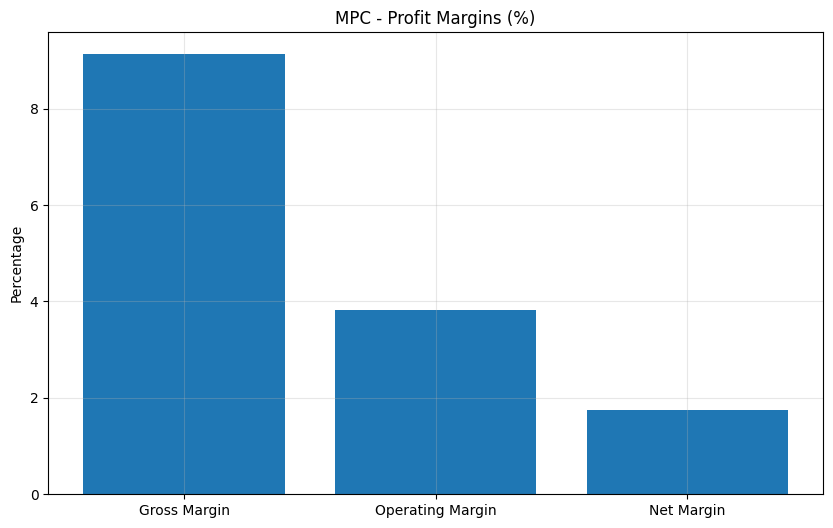

<Figure size 1200x600 with 0 Axes>

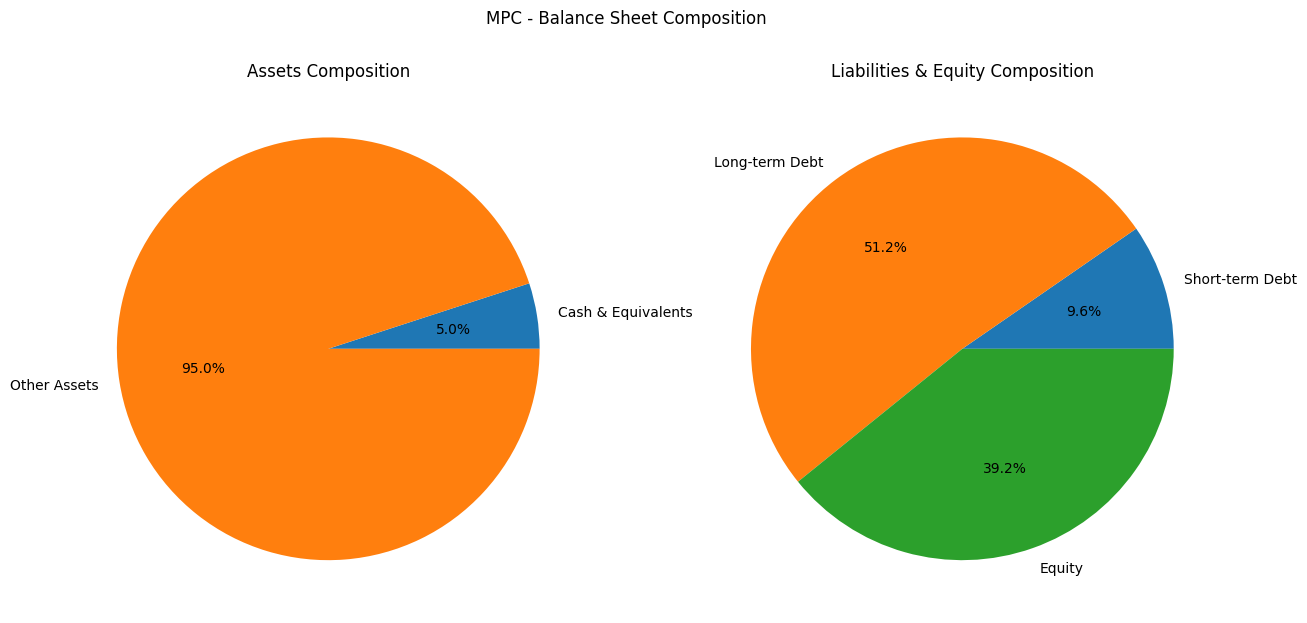

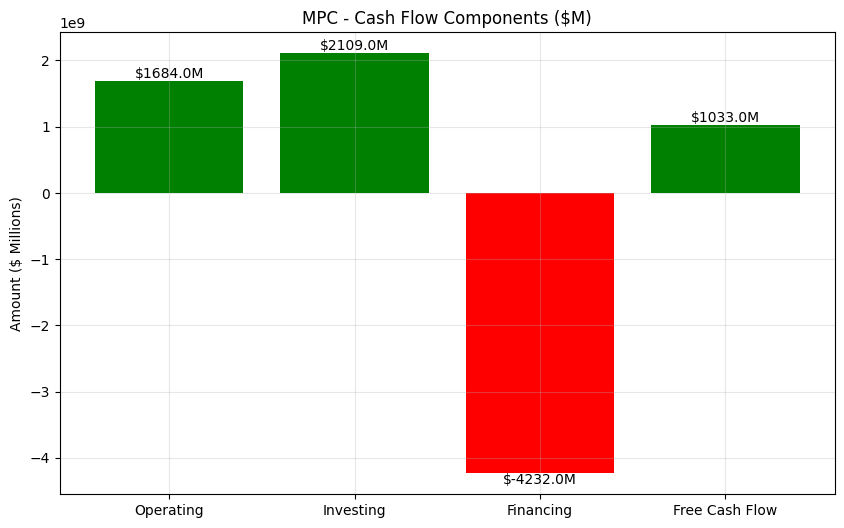

Gross Margin: 9.13%
ROCE: 0.05


<Figure size 640x480 with 0 Axes>

In [ ]:
# Analyze a company
analyzer = analyze_company_financials('MPC')

# Access specific metrics
if analyzer:
    print(f"Gross Margin: {analyzer.metrics.gross_margin:.2f}%")
    print(f"ROCE: {analyzer.metrics.roce:.2f}")

    # Get full summary as DataFrame
    summary_df = analyzer.create_summary_dashboard()

    # Save visualizations
    plt.savefig('financial_analysis.png')